In [1]:
import numpy as np
import torch
from torch import nn
import torch.utils.data as data
import torchvision
import torch.nn.functional as F
from torchvision import transforms
import pathlib
from PIL import Image
import os
import matplotlib.pyplot as plt
import time

In [2]:
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
torch.cuda.is_available()

True

# I. My model 

## A. Prepare the data


In [4]:
transform_generator = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-180, 180)),
    transforms.RandomGrayscale(p=0.3)
])

In [5]:
train_data_path = "./train/"
test_data_path = "./test/"

In [6]:
root = pathlib.Path(train_data_path)

labels = sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [7]:
print('Number of images in train folders:')
print(f'Ganyu: {len(os.listdir(train_data_path + "ganyu"))}')
print(f'Nahida: {len(os.listdir(train_data_path + "nahida"))}')
print(f'Furina: {len(os.listdir(train_data_path + "furina"))}')
print(f'HuTao: {len(os.listdir(train_data_path + "hutao"))}')

Number of images in train folders:
Ganyu: 96
Nahida: 96
Furina: 96
HuTao: 72


In [8]:
print('Number of images in validation folders:')
print(f'Ganyu: {len(os.listdir(test_data_path + "ganyu"))}')
print(f'Nahida: {len(os.listdir(test_data_path + "nahida"))}')
print(f'Furina: {len(os.listdir(test_data_path + "furina"))}')
print(f'HuTao: {len(os.listdir(test_data_path + "hutao"))}')

Number of images in validation folders:
Ganyu: 56
Nahida: 52
Furina: 52
HuTao: 52


## B. Create the model

I create a simple CNN with three convolutional layers and two fully connected layers. 

In [9]:
class Classifier(nn.Module):
    def __init__(self, num_classes=len(labels)):
        super(Classifier, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 32 * 32, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


## C. Training the model

In [10]:
simple_model = Classifier()

if torch.cuda.is_available():
    simple_model.cuda()

In [11]:
transformer_model = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=transformer_model)
test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transformer_model)


In [12]:
batch = 15
train_data_loader = data.DataLoader(train_data, batch_size=batch, shuffle=True)
test_data_loader = data.DataLoader(train_data, batch_size=batch, shuffle=True)

In [13]:
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [14]:
def loss_plot(train_loss, val_loss, name):
    plt.plot(train_loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.legend()
    plt.title(f'{name} Loss')
    plt.show()

In [15]:
train_ls_simple_model = []
val_ls_simple_model = []


def train(model, optim, loss_fn, train_loader, val_loader, train_ls, val_ls, epoch=20, device='cpu'):
    for epoch in range(epoch):
        start_time = time.time()
        training_loss = 0.0
        valid_loss = 0.0

        model.train()
        for batch in train_loader:
            optim.zero_grad()
            inputs, target = batch
            inputs = inputs.to(device)
            target = target.to(device)
            output = model(inputs)
            loss = loss_fn(output, target)
            loss.backward()
            optim.step()
            training_loss += loss.data.item()
        training_loss /= len(train_loader.dataset)
        train_ls.append(training_loss)

        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]

        valid_loss /= len(val_loader.dataset)
        val_ls.append(valid_loss)

        end_time = time.time()
        epoch_time = end_time - start_time
        print(
            'Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}, time = {:.2f} sec.'.format(
                epoch, training_loss,
                valid_loss,
                num_correct / num_examples, epoch_time))


In [16]:
train(simple_model, optimizer, loss_function, train_data_loader, test_data_loader, train_ls=train_ls_simple_model,
      val_ls=val_ls_simple_model, epoch=30, device='cuda')


Epoch: 0, Training Loss: 0.16, Validation Loss: 1.02, accuracy = 0.61, time = 5.62 sec.
Epoch: 1, Training Loss: 0.06, Validation Loss: 0.54, accuracy = 0.79, time = 4.85 sec.
Epoch: 2, Training Loss: 0.04, Validation Loss: 0.38, accuracy = 0.83, time = 7.15 sec.
Epoch: 3, Training Loss: 0.03, Validation Loss: 0.34, accuracy = 0.86, time = 9.07 sec.
Epoch: 4, Training Loss: 0.03, Validation Loss: 0.24, accuracy = 0.92, time = 9.45 sec.
Epoch: 5, Training Loss: 0.02, Validation Loss: 0.26, accuracy = 0.90, time = 7.16 sec.
Epoch: 6, Training Loss: 0.02, Validation Loss: 0.10, accuracy = 0.96, time = 4.83 sec.
Epoch: 7, Training Loss: 0.01, Validation Loss: 0.09, accuracy = 0.98, time = 4.85 sec.
Epoch: 8, Training Loss: 0.01, Validation Loss: 0.05, accuracy = 0.98, time = 4.97 sec.
Epoch: 9, Training Loss: 0.01, Validation Loss: 0.13, accuracy = 0.97, time = 4.83 sec.
Epoch: 10, Training Loss: 0.02, Validation Loss: 0.06, accuracy = 0.99, time = 4.88 sec.
Epoch: 11, Training Loss: 0.01,

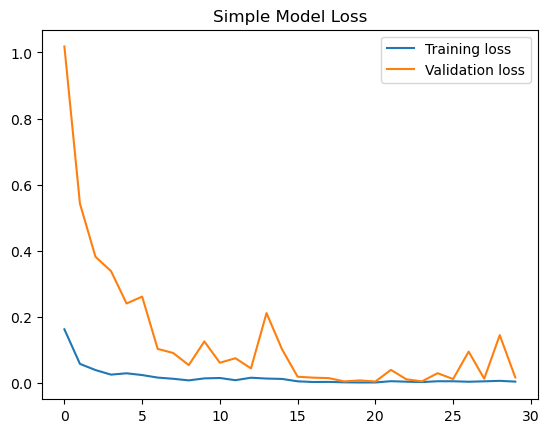

In [17]:
loss_plot(train_ls_simple_model, val_ls_simple_model, 'Simple Model')

In [18]:
torch.save(simple_model.state_dict(), './models/simple_model.pth')

## D. Testing the model on new images

tensor([[-4.2697,  8.0359,  0.2730,  3.7437]], device='cuda:0')
['furina', 'ganyu', 'hutao', 'nahida']
ganyu


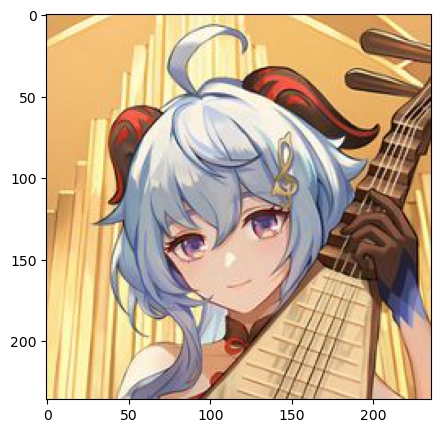

In [19]:
check = Image.open("./other_test/ganyu.jpg").convert('RGB')
show = np.array(check)
plt.figure(figsize=(5, 5))
plt.imshow(show)

check = transformer_model(check).to('cuda')
check = check.unsqueeze(0)

with torch.no_grad():
    output = simple_model(check)
    print(output)
    print(labels)
    print(labels[torch.argmax(output)])

tensor([[-6.0028,  3.4965,  2.2403,  5.7877]], device='cuda:0')
['furina', 'ganyu', 'hutao', 'nahida']
nahida


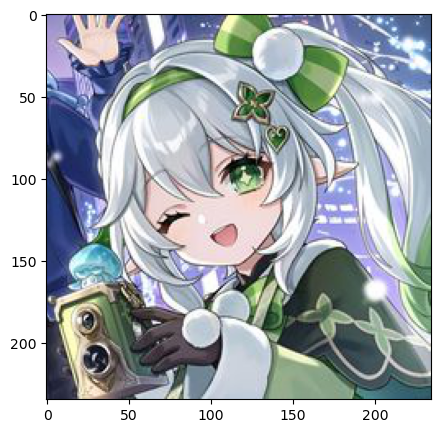

In [20]:
check = Image.open("./other_test/nahida.jpg").convert('RGB')

show = np.array(check)
plt.figure(figsize=(5, 5))
plt.imshow(show)

check = transformer_model(check).to('cuda')
check = check.unsqueeze(0)

with torch.no_grad():
    output = simple_model(check)
    print(output)
    print(labels)
    print(labels[torch.argmax(output)])

tensor([[ 6.4275,  2.1154, -4.1692, -4.2310]], device='cuda:0')
['furina', 'ganyu', 'hutao', 'nahida']
furina


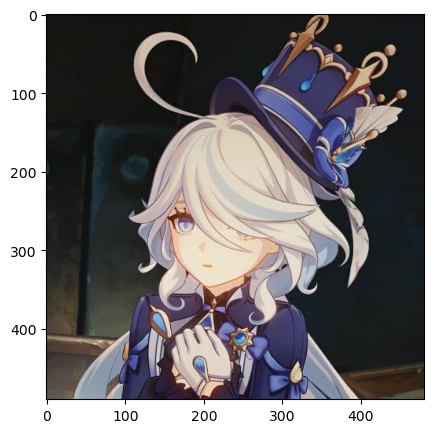

In [21]:
check = Image.open("./other_test/furina.jpg").convert('RGB')

show = np.array(check)
plt.figure(figsize=(5, 5))
plt.imshow(show)

check = transformer_model(check).to('cuda')
check = check.unsqueeze(0)

with torch.no_grad():
    output = simple_model(check)
    print(output)
    print(labels)
    print(labels[torch.argmax(output)])

tensor([[-3.6450,  5.1729, 11.3445, -5.9043]], device='cuda:0')
['furina', 'ganyu', 'hutao', 'nahida']
hutao


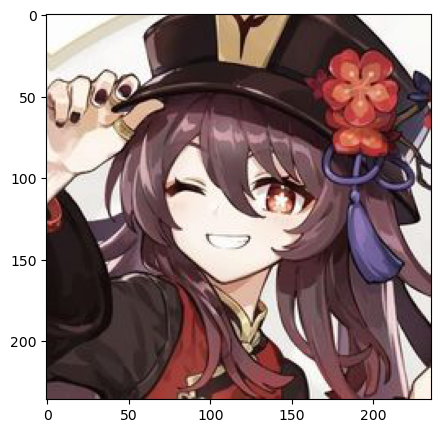

In [22]:
check = Image.open("./other_test/hu_tao.jpg").convert('RGB')

show = np.array(check)
plt.figure(figsize=(5, 5))
plt.imshow(show)

check = transformer_model(check).to('cuda')
check = check.unsqueeze(0)

with torch.no_grad():
    output = simple_model(check)
    print(output)
    print(labels)
    print(labels[torch.argmax(output)])

# II. VGG Net

## A. Initialize the model

In [23]:
weights = torchvision.models.VGG16_Weights.DEFAULT
vgg = torchvision.models.vgg16(weights=weights)
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [24]:
for name, params in vgg.named_parameters():
    params.requires_grad = False

In [25]:
vgg.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=1024, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1024, out_features=len(labels), bias=True)
)

In [26]:
vgg.to('cuda')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## B. Training the model

In [27]:
vgg_transformer = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

vgg_train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=vgg_transformer)
vgg_test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=vgg_transformer)


In [28]:
batch = 15
vgg_train_data_loader = data.DataLoader(train_data, batch_size=batch, shuffle=True)
vgg_test_data_loader = data.DataLoader(train_data, batch_size=batch, shuffle=True)

In [29]:
optimizer = torch.optim.Adam(vgg.parameters(), lr=0.001)

In [30]:
train_ls_vgg = []
val_ls_vgg = []
train(vgg, optimizer, loss_function, vgg_train_data_loader, vgg_test_data_loader, train_ls=train_ls_vgg,
      val_ls=val_ls_vgg, epoch=30, device='cuda')

Epoch: 0, Training Loss: 0.31, Validation Loss: 0.64, accuracy = 0.68, time = 6.59 sec.
Epoch: 1, Training Loss: 0.02, Validation Loss: 0.04, accuracy = 0.99, time = 6.39 sec.
Epoch: 2, Training Loss: 0.01, Validation Loss: 0.01, accuracy = 0.99, time = 6.31 sec.
Epoch: 3, Training Loss: 0.01, Validation Loss: 0.01, accuracy = 1.00, time = 6.34 sec.
Epoch: 4, Training Loss: 0.01, Validation Loss: 0.00, accuracy = 1.00, time = 6.31 sec.
Epoch: 5, Training Loss: 0.01, Validation Loss: 0.01, accuracy = 1.00, time = 6.31 sec.
Epoch: 6, Training Loss: 0.00, Validation Loss: 0.00, accuracy = 1.00, time = 6.32 sec.
Epoch: 7, Training Loss: 0.01, Validation Loss: 0.00, accuracy = 1.00, time = 6.50 sec.
Epoch: 8, Training Loss: 0.03, Validation Loss: 0.03, accuracy = 0.99, time = 6.59 sec.
Epoch: 9, Training Loss: 0.03, Validation Loss: 0.00, accuracy = 1.00, time = 7.22 sec.
Epoch: 10, Training Loss: 0.04, Validation Loss: 0.08, accuracy = 0.99, time = 10.20 sec.
Epoch: 11, Training Loss: 0.05

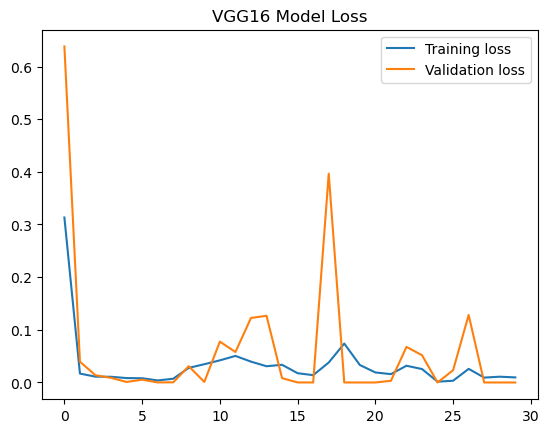

In [31]:
loss_plot(train_ls_vgg, val_ls_vgg, 'VGG16 Model')

In [32]:
torch.save(vgg.state_dict(), './models/vgg_model.pth')

## C. Testing the model on new images

tensor([[-31.2395, -10.3568, -44.2051,  75.2585]], device='cuda:0')
['furina', 'ganyu', 'hutao', 'nahida']
nahida


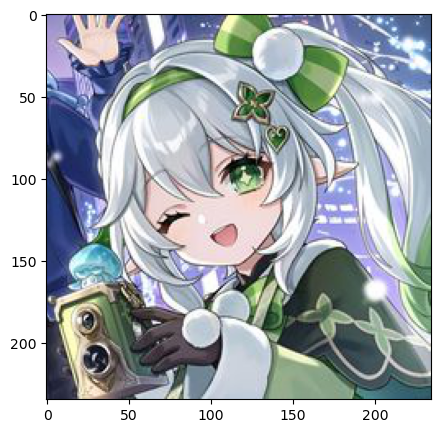

In [33]:
check_vgg = Image.open("./other_test/nahida.jpg").convert('RGB')

show = np.array(check_vgg)
plt.figure(figsize=(5, 5))
plt.imshow(show)

check_vgg = vgg_transformer(check_vgg).to('cuda')
check_vgg = check_vgg.unsqueeze(0)

with torch.no_grad():
    output = vgg(check_vgg)
    print(output)
    print(labels)
    print(labels[torch.argmax(output)])

tensor([[ 152.1234,  -35.9394, -111.2065,  -59.4784]], device='cuda:0')
['furina', 'ganyu', 'hutao', 'nahida']
furina


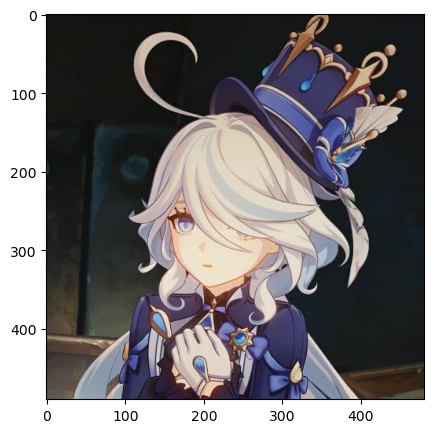

In [34]:
check_vgg = Image.open("./other_test/furina.jpg").convert('RGB')

show = np.array(check_vgg)
plt.figure(figsize=(5, 5))
plt.imshow(show)

check_vgg = vgg_transformer(check_vgg).to('cuda')
check_vgg = check_vgg.unsqueeze(0)

with torch.no_grad():
    output = vgg(check_vgg)
    print(output)
    print(labels)
    print(labels[torch.argmax(output)])